# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

%matplotlib inline

Using TensorFlow backend.


# Preparing Dataset

In [2]:
def load_dataset(fname):
    # read dataset
    dataset = pd.read_csv(fname, comment='#')

    # compositions to wt.%
    dataset.C *= 100
    dataset.Mn *= 100
    dataset.Si *= 100
    dataset.Cr *= 100
    dataset.Ni *= 100

    # temperatures to oC
    dataset.A1 -= 273.15
    dataset.A1prime -= 273.15
    dataset.A3 -= 273.15

    return dataset

In [3]:
def prepare_dataset(fname):
    raw_df = load_dataset(fname)
    
    if set(['file']).issubset(raw_df.columns):
        raw_df = raw_df.drop(['file'], axis=1)
    if set(['macro']).issubset(raw_df.columns):
        raw_df = raw_df.drop(['macro'], axis=1)
    
    df = raw_df.copy()

    df = df.drop(['A1', 'A1prime'], axis=1)
    is_na = df['A3'].isna() 
    df = df.loc[~is_na, :] #REMOVE ALL A3 NAN
    #df['euct'] = (df['eutectoid'].map(lambda x: 1 if x == 'hiper' else 0))
    df= df.drop(['eutectoid'], axis=1) #REMOVE EUCTETOID COLLUMN BECAUSE IT'S A STRING
    
    return df

In [4]:
def normalize_all_data(df):
    scaler = MinMaxScaler(feature_range=[-1, 1])
    scaler.fit(df)
    df.loc[:, :] = scaler.transform(df)
    return df

In [5]:
def split_between_train_and_test(df, size):
    #train size may be 0.8, 0.7 or 0.99
    target = df['A3']
    features = df.iloc[:, :20]
    X_train, X_test, y_train, y_test = train_test_split(
        features,
        target,
        train_size=size,
        random_state=42
    )
    
    X_train = X_train.drop(['A3'], axis=1)
    X_test = X_test.drop(['A3'], axis=1)
    
    print('Train size: {}'.format(X_train.shape))
    print('Test size: {}'.format(X_test.shape))
    return X_train, y_train, X_test, y_test

In [6]:
df = prepare_dataset('../../databases/Tcriticalcopy.csv')
df = normalize_all_data(df)
df.head()

,C,Mn,Si,Cr,Ni,A3
0,-1.0,-1.0,-1.0,-1.0,-1.000000e+00,0.030744
1,-1.0,-1.0,-1.0,-1.0,-5.000000e-01,-0.100664
2,-1.0,-1.0,-1.0,-1.0,-2.220446e-16,-0.213736
3,-1.0,-1.0,-1.0,-1.0,5.000000e-01,-0.312742
4,-1.0,-1.0,-1.0,-1.0,1.000000e+00,-0.400445


In [7]:
X_train, y_train, X_test, y_test = split_between_train_and_test(df, 0.8)

Train size: (5476, 5)
Test size: (1369, 5)


/home/paula/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# The Model

In [46]:
def get_model(hidden_layer_neurons, activation_function, learning_rate, 
              loss_function, epochs, plot=False, file_number = '0'):
    """
    PARAMS
    hidden_layer_neurons: int
    activation_function: tanh, relu, sigmoid
    0 < learning_rate < 1 (I'm not sure)
    loss_function: 'mean_squared_error'
    epochs: int
    """
    
    # Creating a KERAS model
    model = Sequential()
    model.add(Dense(hidden_layer_neurons, input_dim=5, activation=activation_function))
    model.add(Dense(1, activation=activation_function))
    
    opt = optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None, decay=0.0)
    
    model.compile(loss=loss_function, optimizer=opt)
    loss = []
    
    history = model.fit(X_train, y_train, epochs=epochs, verbose=0)
    loss += history.history['loss']
    
    score = model.evaluate(X_test, y_test, verbose=0)
#     print('Test loss (mean squared error):', score)
    
    if plot:
        #Plot Loss
        fig, ax = plt.subplots()
        ax.plot(loss, color='k', label='Loss')
        ax.set_xlabel('Iterações')
        ax.set_ylabel('Perda (erro quadrático médio)')
        plt.title('Neurônios na camada intermediária: ' + file_number)
        plt.savefig('img/loss/'+file_number+'.png')
        
        #Plot Expected x Predicted
        fig, ax = plt.subplots()
        ax.plot(model.predict(X_train), y_train, 'ko')
        ax.plot(model.predict(X_test), y_test, 'kv', mfc='white')
        ax.plot([-1,1],[-1,1],'r-')
        ax.set_xlabel('Valor predito')
        ax.set_ylabel('Valor esperado')
        plt.title('Neurônios na camada intermediária: ' + file_number)
        plt.savefig('img/predict/'+file_number+'.png')

    return score

## Evaluating the effects of the number of hidden layer neurons and learning rate on the score

In [9]:
def test_number_of_neurons(max_neurons, activation_function, learning_rate, 
              loss_function, epochs, plot=False):
    data=[]
    for i in range(1, max_neurons+1):
#         print(i)
        for j in range(5):
            score = get_model(i, activation_function, learning_rate, 
              loss_function, epochs, plot)
            data.append([i, score])
    
    test_df = pd.DataFrame(data, columns=['neurons', 'score'])
    return test_df

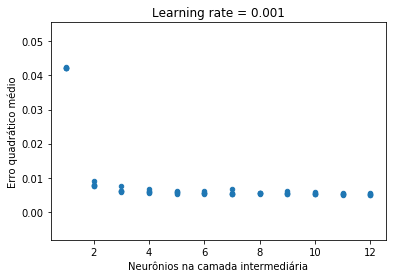

In [25]:
test_001 = test_number_of_neurons(12, 'tanh', 0.001, 'mean_squared_error', 100)

test_001.plot(kind='scatter',x='neurons',y='score')
plt.title('Learning rate = 0.001')
plt.xlabel('Neurônios na camada intermediária')
plt.ylabel('Erro quadrático médio')
plt.savefig('test001')

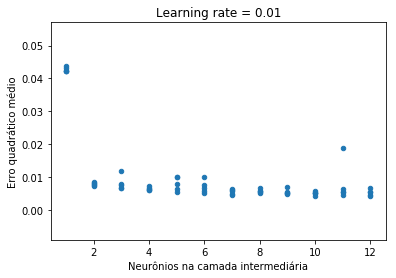

In [26]:
test_01 = test_number_of_neurons(12, 'tanh', 0.01, 'mean_squared_error', 100)

test_01.plot(kind='scatter',x='neurons',y='score')
plt.title('Learning rate = 0.01')
plt.xlabel('Neurônios na camada intermediária')
plt.ylabel('Erro quadrático médio')
plt.savefig('test01')

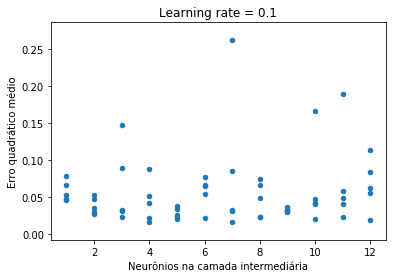

In [41]:
test_1 = test_number_of_neurons(12, 'tanh', 0.1, 'mean_squared_error', 100)

test_1.plot(kind='scatter',x='neurons',y='score')
plt.title('Learning rate = 0.1')
plt.xlabel('Neurônios na camada intermediária')
plt.ylabel('Erro quadrático médio')
plt.savefig('test1')

## Evaluating the effects of the number of hidden layer neurons in loss and predictions values

In [47]:
def evaluate_loss_and_predictions(max_neurons, activation_function, learning_rate, 
              loss_function, epochs):
    for i in range(1, max_neurons+1):
        get_model(i, activation_function, learning_rate, 
                  loss_function, epochs, True, str(i))

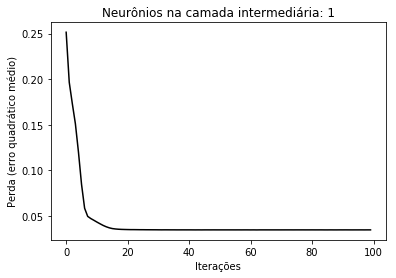

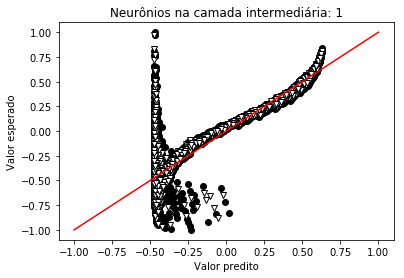

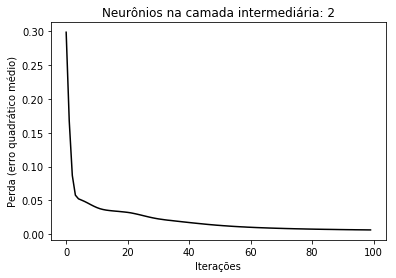

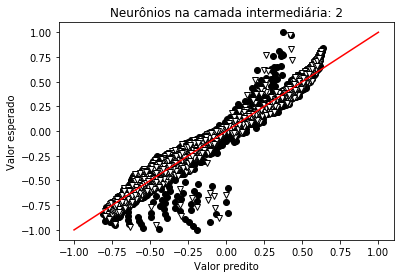

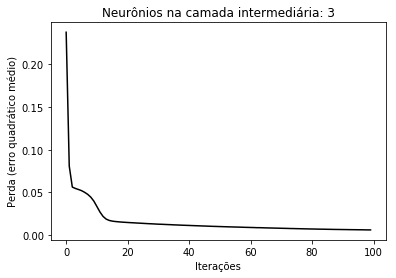

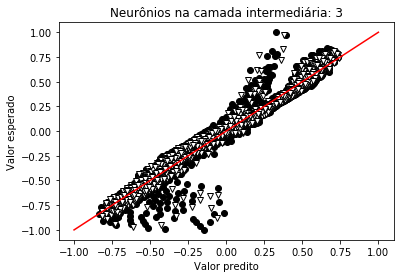

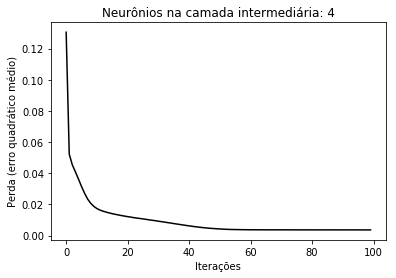

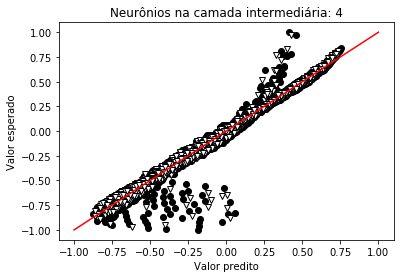

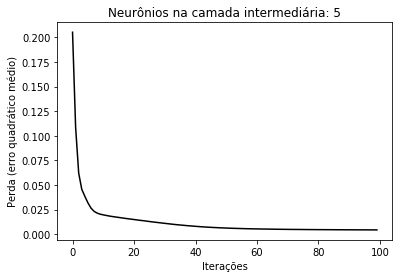

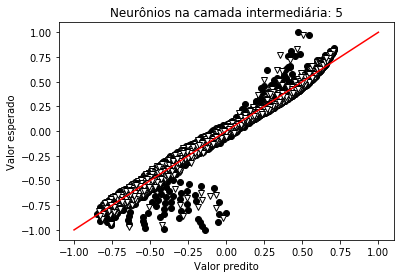

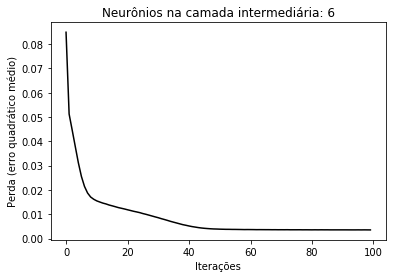

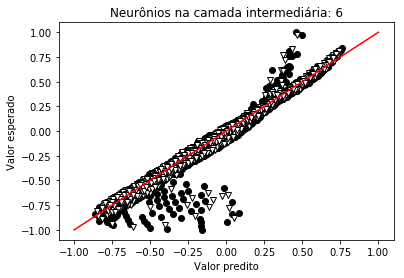

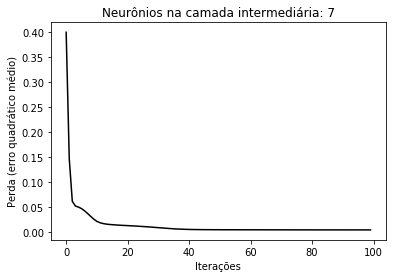

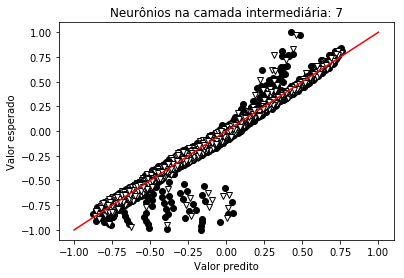

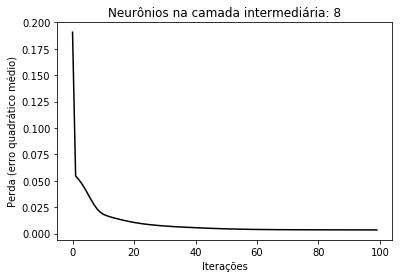

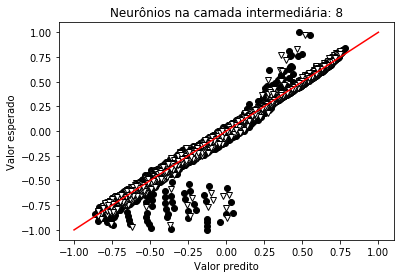

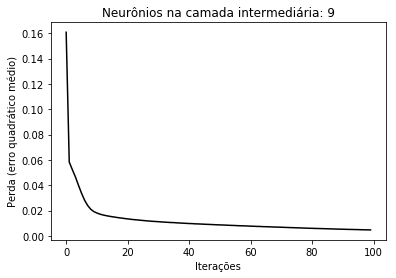

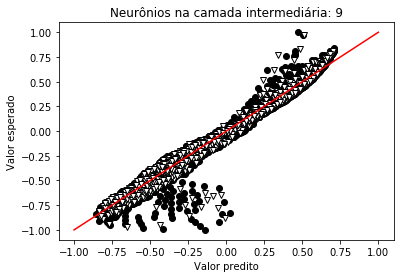

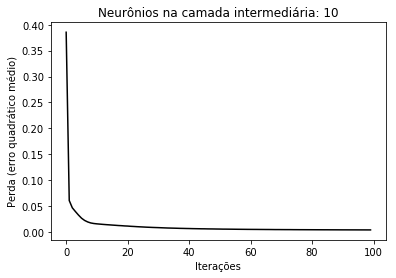

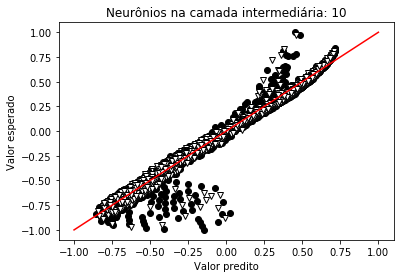

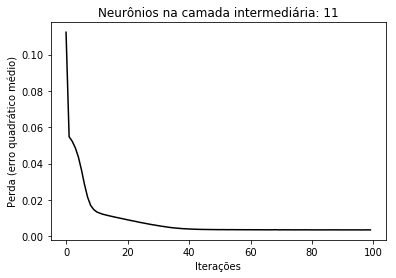

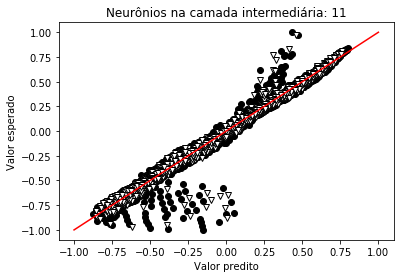

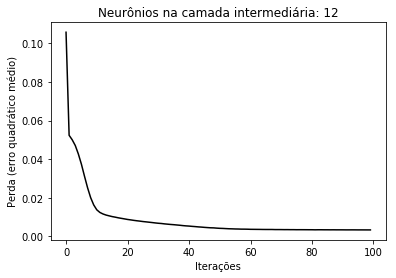

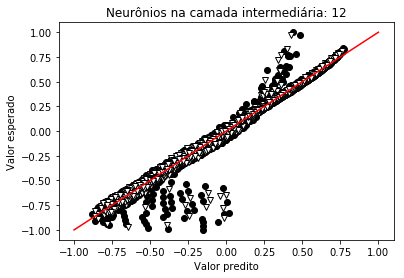

In [48]:
evaluate_loss_and_predictions(12, 'tanh', 0.001, 'mean_squared_error', 100)